# План работы

1. Изучение поставленной задачи;
1. Получение первоначальной информации о проекте;
2. Анализ имеющейся информации. Работа с данными: обработка некорректных значений, аномалий и пропусков.
3. Разделение выборки на `features` and `target`;
4. Feature engineering;
5. Поиск оптимальной модели;
6. Тестирование модели;
7. Вывод.

# Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
  
Также доступны такие услуги:

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
  
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


### Описание данных

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.
  
Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.



In [51]:
#Код ревьюера
#!pip install phik
#!pip install category_encoders
#!pip install scikit-learn==1.1.3

# Imports

In [52]:
import os
import time
import warnings
warnings.filterwarnings('ignore')

from copy import copy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import phik

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (roc_auc_score,
                            confusion_matrix,
                            accuracy_score,
                            roc_curve)

from category_encoders import *

# Random seed

In [54]:
RANDOM_SEED = 110923

# Class `Telecommunication`

In [55]:



class Telecommunication:

    #часть 1. План работы
    def __init__(self, path):
        self.contract = pd.read_csv(f'{path}contract_new.csv', index_col='customerID')
        self.personal = pd.read_csv(f'{path}personal_new.csv', index_col='customerID')
        self.internet = pd.read_csv(f'{path}internet_new.csv', index_col='customerID')
        self.phone = pd.read_csv(f'{path}phone_new.csv', index_col='customerID')
        self.models = {}
        
    def fix_type_of_data(self):
        self.contract['BeginDate'] = pd.to_datetime(self.contract['BeginDate'], format='%Y-%m-%d')
        self.contract['TotalCharges'] = pd.to_numeric(self.contract['TotalCharges'], errors='coerce')
        self.contract[['BeginDate', 'TotalCharges']].info()
        
    def leaved_id(self):
        self.leaved_id = self.contract[self.contract['EndDate'] != 'No'].index
        print("Процент оттока клиентов в представленных данных составляет: {:.2%}".format(
                    self.contract[self.contract['EndDate'] != 'No']['EndDate'].count() /
                     self.contract['EndDate'].count()
                ))
        
    def fix_citizen_status(self):
        
        self.personal['SeniorCitizen'] = np.where(self.personal['SeniorCitizen'] == 0, "No", 'Yes')
        
    
    @classmethod
    def barplot_features(cls, ds, leaved_id, name):
        columns = ds.columns
        num_rows = len(columns) // 2 + len(columns) % 2

        fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
        axes = axes.ravel()

        for i, col in enumerate(columns):
            ax = axes[i]
            sns.barplot(x=ds[col].value_counts().sort_index(ascending=True),
                        y=ds[col].value_counts().sort_index(ascending=True).index,
                        ax=ax,
                        palette='Set3', alpha=.5)

            sns.barplot(x=ds[ds.index.isin(leaved_id)][col].value_counts().sort_index(ascending=True),
                        y=ds[ds.index.isin(leaved_id)][col].value_counts().sort_index(ascending=True).index,
                        ax=ax,
                        palette='Set3')

            ax.set_xlabel('Количество пользователей\n')
            ax.set_ylabel(f'{col}')
            ax.set_title(f'По колонке {col}\n')

            leavers_per = (ds[ds.index.isin(leaved_id)][col]
               .value_counts()
               .sort_index(ascending=True)
                /
                ds[col]
                .value_counts()
                .sort_index(ascending=True))

            for i_lp, val in enumerate(leavers_per):
                ax.text(ds[ds.index.isin(leaved_id)][col].value_counts().sort_index(ascending=True)[i_lp] + 300, i_lp, '{:2.2%}'.format(val), ha='center', va='center', fontsize=10)

        if len(columns) % 2 != 0:
            fig.delaxes(axes[-1])

        plt.suptitle(f'Диаграммы отношения ушедших пользователей ко всем пользователям\n в датафрейме {name}\n', fontsize=16)

        plt.tight_layout()
        
    # Часть 2. Код решения
    
    def concat_datasets(self):
        

        self.df_full = self.contract.merge(self.internet, how='left', left_index=True, right_index=True)
        self.df_full = self.df_full.merge(self.phone, how='left', left_index=True, right_index=True)
        self.df_full = self.df_full.merge(self.personal, how='left', left_index=True, right_index=True)
        
        
        print(f'Количество уникальных пользователей в первоночальном датасете: {len(set(self.contract.index))}')
        print(f'Количество строк в полном датасете: {len(set(self.df_full.index))}')
        
    def get_features(self):
        self.df_full['duration'] = (pd.to_datetime(np.where(self.df_full['EndDate'] != 'No',
                                                            self.df_full['EndDate'],
                                                            '2020-02-01')) - self.df_full['BeginDate']).dt.days
        
        self.df_full.drop(columns=['BeginDate','MonthlyCharges'], inplace=True)
        
        self.df_full['Status'] = np.where(self.df_full['EndDate'] == 'No', 0 , 1)
        
        self.df_full.drop(columns=['EndDate'], inplace=True)
        
    def features_train_splitter(self):

        self.features = self.df_full.drop(columns=['Status'])
        self.target = self.df_full['Status']
        
        print(f'Размер выборки признаков: строк - {self.features.shape[0]}, столбцов - {self.features.shape[1]}')
        print(f'Размер целевой выборки: строк - {self.target.shape[0]}')

    def features_corr(self):
        
        corr_matrix = self.features.phik_matrix(interval_cols=['MonthlyCharges','TotalCharges','duration'])
        my_cmap = copy(plt.cm.YlGnBu)
        my_cmap.set_under("white")
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        fig, ax = plt.subplots(figsize=(13, 13))
        sns.heatmap(corr_matrix, annot=True, cmap=my_cmap, linewidths=0.5, ax=ax, center=0, vmin=.9, mask=mask)
        ax.set_title('Карта корреляций\n', fontsize=20)
        plt.show()
        
    def fix_corr_feature(self):
        
        col = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
        self.features['AmountOfService'] = (~self.features[col].isin(['No','NoValue'])).sum(axis=1)
        self.features.drop(columns=col,inplace=True)
        self.features.drop(columns=['InternetService'])
        
    
    def target_features_corr(self):
        full = self.features.join(self.target)
        corr_matrix = full.phik_matrix(interval_cols=['MonthlyCharges','TotalCharges','duration'])


        my_cmap = copy(plt.cm.YlGnBu)
        my_cmap.set_under("white")
        
        fig, ax = plt.subplots()
        sns.heatmap(pd.DataFrame(corr_matrix['Status']), annot=True, cmap=my_cmap, linewidths=0.5, ax=ax, center=0)
        ax.set_title('Карта корреляций target и features\n', fontsize=20)
        plt.show()
        
    def train_test_splitter(self, print_status=False):
        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(self.features,
                                                                                                        self.target, 
                                                                                                        test_size=.25,
                                                                                                        random_state=RANDOM_SEED)
        
        
        if print_status:
            print(f'Размер тренировочной выборки: {self.features_train.shape[0]} строк и {self.features_train.shape[1]} колонок')
            print(f'Размер тестовой выборки: {self.features_test.shape[0]} строк и {self.features_test.shape[1]} колонок')
    
    

    def Regression_model(self,print_status=False):
        
        start_time = time.time()
        
        cat_cols = self.features_train.select_dtypes(include=["object"]).columns.tolist()
        num_cols = self.features_train.select_dtypes(exclude=["object"]).columns.tolist()
        
        cat_preprocessing_ohe = make_pipeline(
            OneHotEncoder(handle_unknown="error"),
            #OneHotEncoder(drop='first',handle_unknown="error"),
        )
        
        num_preprocessing = make_pipeline(StandardScaler())
        
        
        preprocessing_full = ColumnTransformer(
            [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing_ohe, cat_cols)]
        )
        
        model = LogisticRegression(random_state=RANDOM_SEED, verbose=0)
        
        regression_pipeline = Pipeline(steps=[
            ('preprocessor',preprocessing_full),
            ('classifier', model)
        ])
        
        param_grid = {
            'classifier__C' : np.arange(0.1,4,0.2),
            'classifier__penalty' : ['l2']
        }
        
        model_pipeline_result = RandomizedSearchCV(regression_pipeline,param_grid, scoring='roc_auc', random_state=RANDOM_SEED)
        
        self.LogisticRegression = model_pipeline_result.fit(self.features_train, self.target_train)
        
        self.models['LogisticRegression'] = {'time': time.time() - start_time}
        self.models['LogisticRegression']['score'] = self.LogisticRegression.best_score_
        
        if print_status:
            print('Лучшая модель "LogisticRegression" на трейне имеет оценку roc_auc: {:.3f}.'.format(self.LogisticRegression.best_score_))
    
    def RandomForest_model(self, print_status=False):
        
        start_time = time.time()
        
        cat_cols = self.features_train.select_dtypes(include=["object"]).columns.tolist()
        num_cols = self.features_train.select_dtypes(exclude=["object"]).columns.tolist()
        
        cat_preprocessing_ohe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
        )
        
        num_preprocessing = make_pipeline(StandardScaler())
        
        
        preprocessing_full = ColumnTransformer(
            [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing_ohe, cat_cols)]
        )
        
        model = RandomForestClassifier(random_state=RANDOM_SEED)
        
        regression_pipeline = Pipeline(steps=[
            ('preprocessor',preprocessing_full),
            ('classifier', model)
        ])
        
        param_grid = {
            'classifier__n_estimators' : np.arange(1,400),
            'classifier__max_depth' : np.arange(1,20),
            'classifier__min_samples_split': np.arange(3,10),
            'classifier__min_samples_leaf': np.arange(2,5)
        }
        
        model_pipeline_result = RandomizedSearchCV(regression_pipeline,param_grid, scoring='roc_auc',cv=5, random_state=RANDOM_SEED)

        self.RandomForestClassifier = model_pipeline_result.fit(self.features_train, self.target_train)
        
        self.models['RandomForestClassifier'] = {'time': time.time() - start_time}
        self.models['RandomForestClassifier']['score'] = self.RandomForestClassifier.best_score_
        
        if print_status:
            print('Лучшая модель "RandomForestClassifier" на трейне имеет оценку roc_auc: {:.3f}.'.format(self.RandomForestClassifier.best_score_))
    
    def CatBoostClassifier_model(self, print_status=False):
        
        start_time = time.time()
        
        cat_cols = self.features_train.select_dtypes(include=["object"]).columns.tolist()
        num_cols = self.features_train.select_dtypes(exclude=["object"]).columns.tolist()
        
        cat_preprocessing_ohe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
        )
        
        num_preprocessing = make_pipeline(StandardScaler())
        
        
        preprocessing_full = ColumnTransformer(
            [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing_ohe, cat_cols)]
        )
        
        model = CatBoostClassifier(random_state=RANDOM_SEED, silent=True)
        
        catboost = Pipeline(steps=[
            ('preprocessor',preprocessing_full),
            ('classifier', model)
        ])
        
        param_grid = {'classifier__iterations': np.arange(50, 200, 10),
                    'classifier__learning_rate': np.arange(0.03, 0.1, 0.03),
                    'classifier__depth': np.arange(4,10),
                    'classifier__l2_leaf_reg': np.arange(2,7,2)
        }
        
        self.CatBoost = RandomizedSearchCV(catboost, param_grid, n_iter=15,cv=5, scoring='roc_auc', random_state=RANDOM_SEED)
        
        self.CatBoost.fit(self.features_train, self.target_train)
        
        self.models['CatBoost'] = {'time' : time.time() - start_time}
        self.models['CatBoost']['score'] = self.CatBoost.best_score_
        
        if print_status:
            print('Лучшая модель "CatBoostClassifier" на трейне имеет оценку roc_auc: {:.3f}.'.format(self.CatBoost.best_score_))
            
    
    @classmethod
    def LGBM_features_transformation(cls, features):
        cat_cols = features.select_dtypes(include=["object"]).columns.tolist()
        for feature in cat_cols:
            features[feature] = pd.Series(features[feature], dtype="category")
        return features
    
    def LGBM_model(self, print_status=False):
        
        start_time = time.time()
        
    
        model = LGBMClassifier(random_state=RANDOM_SEED)
        
        
        param_grid = {
            'n_estimators' : np.arange(1,400),
            'max_depth' : np.arange(1,20),
            'learning_rate': np.arange(0.03, 0.1, 0.03),
        }
        
        
        features = Telecommunication.LGBM_features_transformation(self.features_train)
        
        self.LGBM = RandomizedSearchCV(model, param_grid, n_iter=20,cv=5, scoring='roc_auc', random_state=RANDOM_SEED)
        
        self.LGBM.fit(features, self.target_train)
        
        self.models['LGBM'] = {'time' : time.time() - start_time}
        self.models['LGBM']['score'] = self.LGBM.best_score_
        
        if print_status:
            print('Лучшая модель "LGBM" на трейне имеет оценку roc_auc: {:.3f}.'.format(self.LGBM.best_score_))
        
    def train_all_models(self, print_status=False):
        self.Regression_model(print_status=print_status)
        self.RandomForest_model(print_status=print_status)
        self.CatBoostClassifier_model(print_status=print_status)
        self.LGBM_model(print_status=print_status)
        
        
    @classmethod
    def plot_confusion_matrix(cls,predictions, target):
        matrix = confusion_matrix(predictions, target)
        
        
        fig, ax = plt.subplots(figsize=(13, 13))
        sns.heatmap(matrix, annot= True , fmt="d",  cmap='Blues', ax=ax)
        
        ax.set_title('Матрица ошибок\n')
        ax.set_xlabel('\nPredicts')
        ax.set_ylabel('Target')
        
        
        ax.xaxis.set_ticklabels(['False','True'])
        ax.yaxis.set_ticklabels(['False','True'])
        
    @classmethod
    def plot_features_importances(cls, feature_importance, columns_name):
        df = pd.DataFrame(feature_importance, index=columns_name)
        fig, ax = plt.subplots(figsize=(13, 13))
        sns.barplot(x=df.sort_values(by=0, ascending=False).values.reshape((12,)),
                y=np.array(df.sort_values(by=0, ascending=False).index),
                ax=ax)
        
        ax.set_title('Важность признаков\n')
        ax.set_xlabel('\nВажность')
        ax.set_ylabel('Признак')
        
    
    @classmethod
    def plot_roc_auc_score(self,target, proba):
        fpr, tpr, thresholds = roc_curve(target, proba, pos_label=1)
        roc_auc = roc_auc_score(target, proba)
        
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

In [56]:
try:
  telecommunication_analysis = Telecommunication(f'{os.getcwd()}/')
except:
  telecommunication_analysis = Telecommunication('https://code.s3.yandex.net/datasets/')

# Предобработка данных

### dataset - contact_new.csv

#### Первоначальная информация

In [57]:
telecommunication_analysis.contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [58]:
telecommunication_analysis.contract.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
8250-ZNGGW,2019-09-01,No,Month-to-month,No,Credit card (automatic),59.90,299.5
6298-QDFNH,2018-02-01,2019-07-01,Month-to-month,Yes,Electronic check,79.35,1389.42
0156-FVPTA,2018-01-01,2019-10-01,Month-to-month,Yes,Electronic check,54.20,1138.2
5850-BDWCY,2019-08-01,No,Month-to-month,No,Mailed check,20.20,127.26
9300-AGZNL,2019-12-01,No,Month-to-month,Yes,Electronic check,94.00,201.16


Датасет `contract` состоит из `7043` уникальных строк. Каждая строка относится к уникальному id клиенту - `customerID`.

При этом для каждого клиента имеются следующие данные `BeginDate`,`EndDate`, `Type`,`PaperlessBilling`,`MonthlyCharges`,`TotalCharges`.

Между с тем, тип данных в колонках `BeginDate` и `TotalCharges` указан не корректно. Исправим это:

In [59]:
telecommunication_analysis.fix_type_of_data()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   BeginDate     7043 non-null   datetime64[ns]
 1   TotalCharges  7032 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 165.1+ KB


В данных `TotalCharges` имеется `10` пропусков. Посмотрим на них:

In [60]:
index_null = telecommunication_analysis.contract[telecommunication_analysis.contract['TotalCharges'].isnull()].index
telecommunication_analysis.contract[telecommunication_analysis.contract['TotalCharges'].isnull()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN


Все данные принадлежат данным за определенный месяц - февраль 2020 года. Из описании данных мы знаем, что этот месяц является последним доступным месяцем в датасете:

In [61]:
telecommunication_analysis.contract['BeginDate'].describe(datetime_is_numeric=True)[['min','max']]

min    2013-10-01 00:00:00
max    2020-02-01 00:00:00
Name: BeginDate, dtype: object

В связи с этим можно заполнить пропуски значением из колонки `MonthlyCharges`. Однако при дальнейшей работе с классом следует учитывать этот момент, чтобы не дублировать первую оплату:

In [62]:
telecommunication_analysis.contract['TotalCharges'] = np.where(
                                                      (telecommunication_analysis.
                                                       contract['TotalCharges'].isnull()) &
                                                      (telecommunication_analysis.
                                                       contract['BeginDate'] == 
                                                       telecommunication_analysis.
                                                       contract['BeginDate'].describe(datetime_is_numeric=True)['max']),
                                                      telecommunication_analysis.contract['MonthlyCharges'],
                                                      telecommunication_analysis.contract['TotalCharges'])

Проверим корректность замены:

In [63]:
telecommunication_analysis.contract[telecommunication_analysis.contract.index.isin(index_null)].sample(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25


In [64]:
del index_null

#### Анализ данных

In [65]:
telecommunication_analysis.contract[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


Для ежемесячных платежей:
* `Средняя` плата составляет `64.76`;
* `минимальная` - `18.25`;
* `максимальная` - `118.75`.
  
За всё время:
* `Средняя` общая оплата составила `2118.621822`;
* `минимальная` - `19`;
* `максимальная` - `9221.3`.

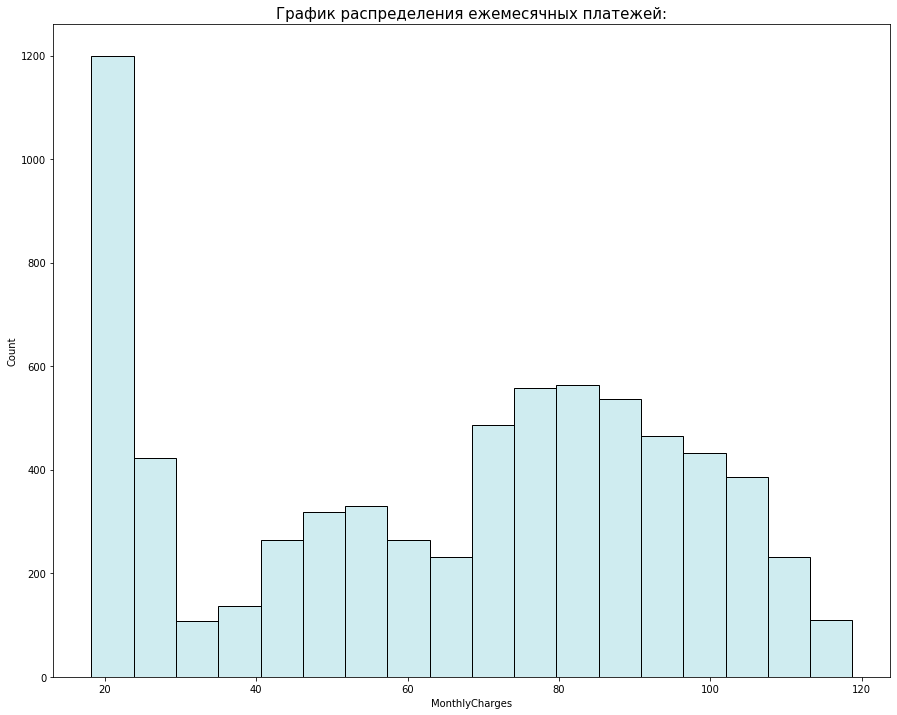

In [66]:
plt.figure(figsize=[15, 12])
plt.title('График распределения ежемесячных платежей:', fontsize=15)
sns.histplot(telecommunication_analysis.contract['MonthlyCharges'], color='powderblue', alpha=0.6)
plt.show()

На графике ежемесячных платежей наблюдается пик на уровне `20`. Далее, если не брать в расчёт эту категорию клиентов, наблюдается нормальное распределение со средним на уровне `80`-`90`. Можно предположить, что это связано с тем, что имеется множество клиентов со счетами без дополнительных услуг. В случае же, когда клиент пользуется дополнительными услугами, распределение приобретает иной вид. Посмотрим на график суммарных платежей:

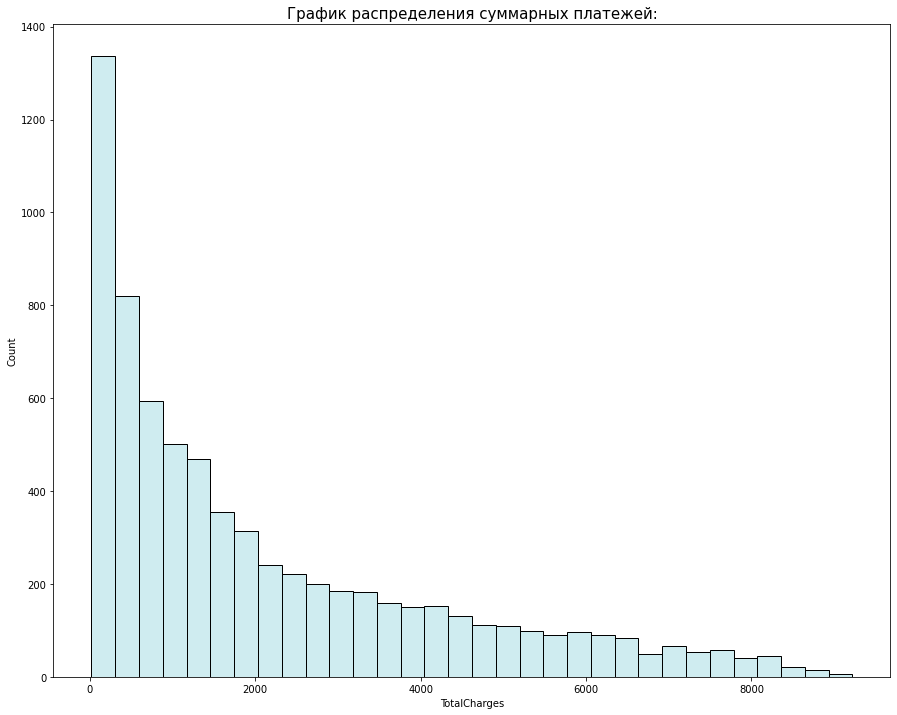

In [67]:
plt.figure(figsize=[15, 12])
plt.title('График распределения суммарных платежей:', fontsize=15)
sns.histplot(telecommunication_analysis.contract['TotalCharges'], color='powderblue', alpha=0.6)
plt.show()

График распределения суммарных платежей представляет собой монотонно убывающую кривую с пиком около нуля и правым хвостом на уровне `9221.38`.

Данный пик может свидетельствовать о трех вещах:
1. Клиенты отказываются от сервиса в первые месяца;
2. Множество новых клиентов, которые еще не успели набрать большую общую сумму платежей;
3. Множество клиентов с пакетом дешевых услуг.

In [68]:
time_user = (
            pd.to_datetime(telecommunication_analysis.
                           contract[telecommunication_analysis.
                                    contract['EndDate'] != 'No']['EndDate']) -
                            telecommunication_analysis.
                            contract[telecommunication_analysis.
                                     contract['EndDate'] != 'No']['BeginDate']
            )

In [69]:
time_user.value_counts().head(10)

1461 days    18
1035 days    14
153 days     13
792 days     13
822 days     13
1096 days    13
334 days     12
1308 days    12
365 days     12
1614 days    11
dtype: int64

Как мы можем наблюдать, чаще всего клиенты перестают пользоваться услугами больше, чем через через год. Построим график распределения:

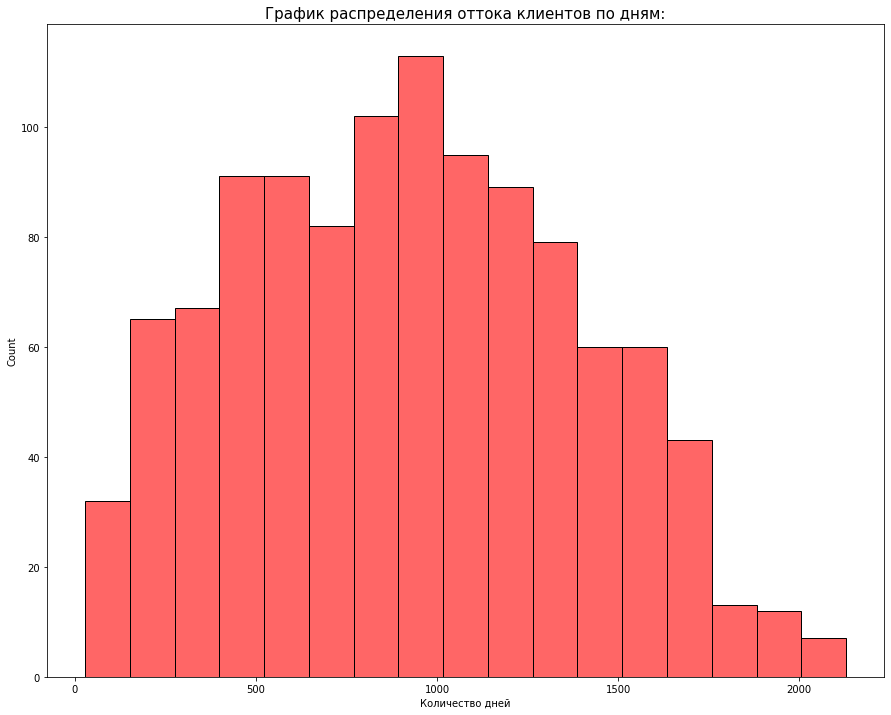

In [70]:
plt.figure(figsize=[15, 12])
plt.title('График распределения оттока клиентов по дням:', fontsize=15)
plt.xlabel('Количество дней')
sns.histplot(time_user.dt.days, color='Red', alpha=0.6)
plt.show()

Действительно, клиентов, которые уходят в первые дни - мало. Кривая окончания пользования услугами плавно возрастает и начинает свое снижение примерно на ~ 3 годах пользования сервисами. Таким образом, наиболее опасная группа с точки зрения оттока клиентов - от ~ `года` до `3-х лет`.

In [71]:
time_using = (
            pd.to_datetime('2020-02-01') -
            telecommunication_analysis.
            contract[telecommunication_analysis.
                     contract['EndDate'] == 'No']['BeginDate']
            )

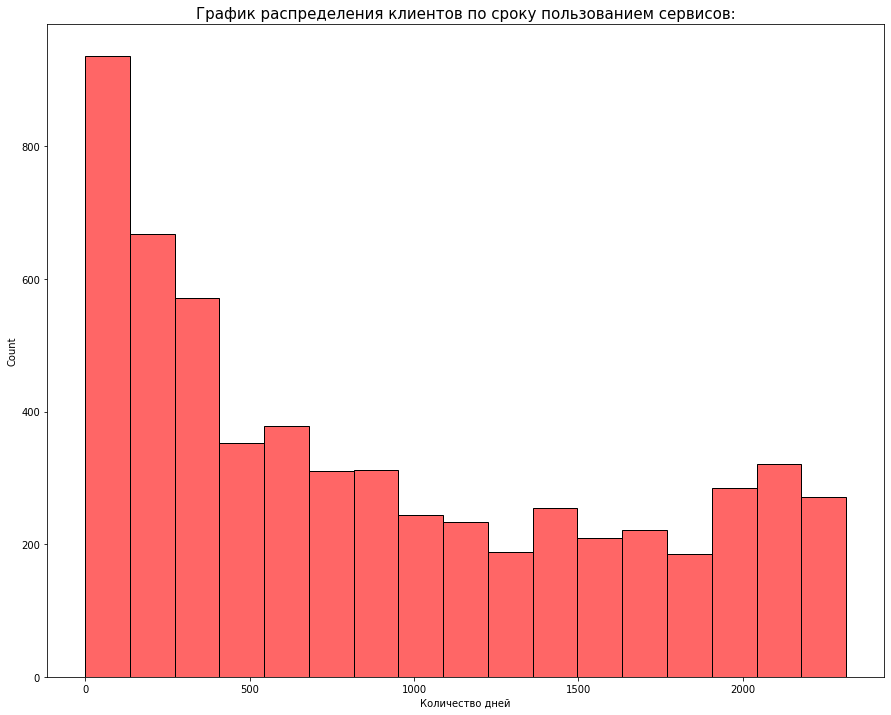

In [72]:
plt.figure(figsize=[15, 12])
plt.title('График распределения клиентов по сроку пользованием сервисов:', fontsize=15)
plt.xlabel('Количество дней')
sns.histplot(time_using.dt.days, color='Red', alpha=0.6)
plt.show()

Действительно наблюдается множество новых клиентов. Это является одной из причин, почему пик суммарных платежей клиентов находится около нуля.

Попробуем составить портрет клиента, который ушел:

In [73]:
telecommunication_analysis.leaved_id()

Процент оттока клиентов в представленных данных составляет: 15.63%


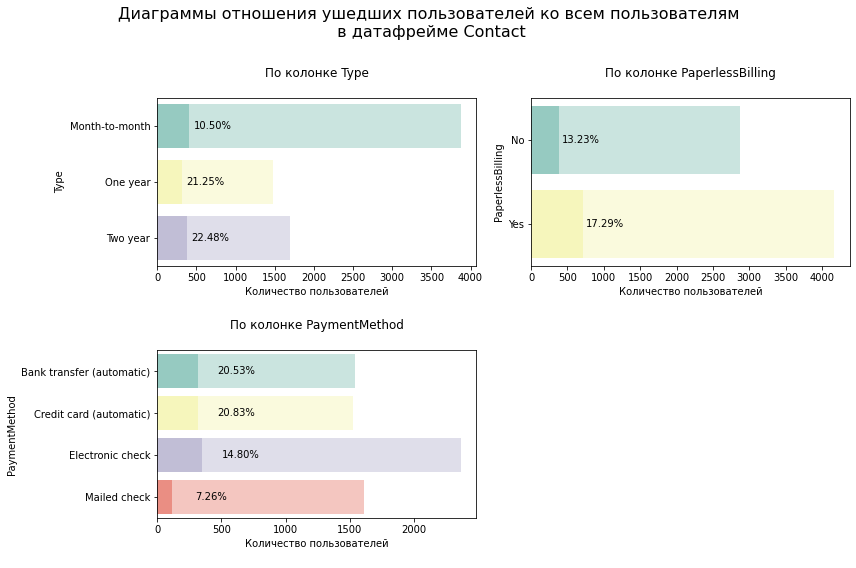

In [74]:
telecommunication_analysis.barplot_features(telecommunication_analysis
                                            .contract
                                            .drop(columns=['BeginDate','EndDate','MonthlyCharges','TotalCharges']),
                                                            telecommunication_analysis.leaved_id,
                                                            'Contact')

1. Тип платежей

Больше половины оплачивают подписку ежемесячно (`55%`), в то время как `24.1%` оплачивают подписку раз в два года, ещё `20.9%` оплачивают годовую подписку.

Что касается клиентов, которые ушли, то тут картинка несколько иная:

* Клиенты, которые оплачивают подписку ежемесячно в абсолютном соотношение уходят больше всех. Однако в процентном соотношении таких меньше, всего - `10.5%`;
* Что касается двух друг групп, у которых годовой и 2х годовой план подписки, то здесь уже уходят `21.25%` и `22.48%` соответственно.

Наблюдается интересная ситуация, когда лояльные клиенты, готовые оплачивать сервис на год и более уходят чаще. Это может быть связано с несколькими факторами:
* Вероятно, нельзя менять корректировать выбранный пакеты услуг. В связи с чем, по истечению срока, клиенты выбирают другой, более выгодный сервис;
* Возможно, что среднее время пользованием услуг в данном регионе составляет 2 года.

2. Уведомление по электронной почте

Больше клиентов (`4171`) получают уведомления только по электронной почте, чем получают обычной почтой (`2872`). При этом те, кто получают по электронной почте реже уходят, тем те, кто получает физический носитель.

3. Способ оплаты

Здесь данные распределены примерно по ровну.

* Первая часть оплачивает автоматически с помощью кредитных карт (`21.6%`) и банковского перевода (`21.9%`).
* Вторая часть оплачивает в ручном режиме: наибольший процент (`33.6%`) прибегает к услуге Electronic check, на втором месте Mailed check (`22.9%`).

Вероятно, что клиенты, которые используют автоплатеж являются более лояльными, чем те, кто платит в ручном режиме.

### dataset - internet_new.csv

#### Первоначальная информация

In [75]:
telecommunication_analysis.internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [76]:
telecommunication_analysis.internet.sample(5)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
4566-QVRRW,DSL,No,No,No,No,No,No
3740-RLMVT,DSL,Yes,Yes,No,Yes,No,No
2657-ALMWY,Fiber optic,No,Yes,No,No,No,Yes
8181-YHCMF,DSL,No,Yes,Yes,Yes,Yes,Yes
3466-RITXD,Fiber optic,Yes,Yes,No,No,Yes,No


Значений в этом датафрейме меньше, чем в общем с клиентами.  Вероятно, это те клиенты, кто пользуется только телефонной связью. Проверим:

In [77]:
diff_id = list(set(telecommunication_analysis
                   .contract
                   .index) - set(telecommunication_analysis
                                 .internet
                                 .index))

print(f'В датафрейме phone присутствуют {telecommunication_analysis.contract[telecommunication_analysis.contract.index.isin(diff_id)].shape[0]} строк, отсутствующих в датафрейме Internet')

В датафрейме phone присутствуют 1526 строк, отсутствующих в датафрейме Internet


Таким образом, в датафрейме, вероятно, нет пропусков и все клиенты с интернет услугами учтены

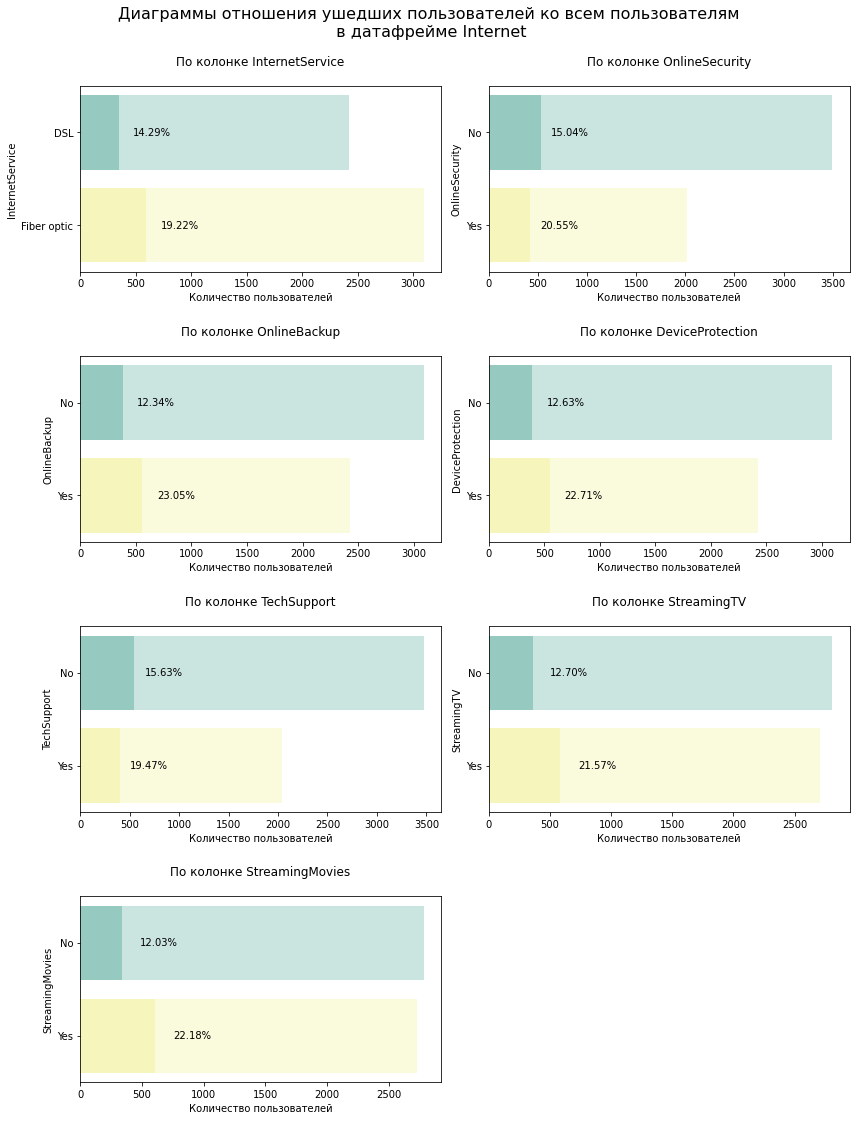

In [78]:
telecommunication_analysis.barplot_features(telecommunication_analysis.internet,
                                            telecommunication_analysis.leaved_id, 'Internet')

In [79]:
telecommunication_analysis.internet.value_counts().head(3)

InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies
Fiber optic      No              No            No                No           No           No                 399
DSL              No              No            No                No           No           No                 294
Fiber optic      No              No            No                No           Yes          Yes                181
dtype: int64

Самая популярная услуга: обычный интернет с двумя типами подключения `Fiber optic` и `DSL` без дополнительных опций. Самая популярная дополнительная опция - `StremingTV` и `StreamingMovie`.

В соотношении ушедших клиентов к общему числу клиентов не найдено каких-либо аномалий.

### dataset - phone_new.csv

In [80]:
telecommunication_analysis.phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


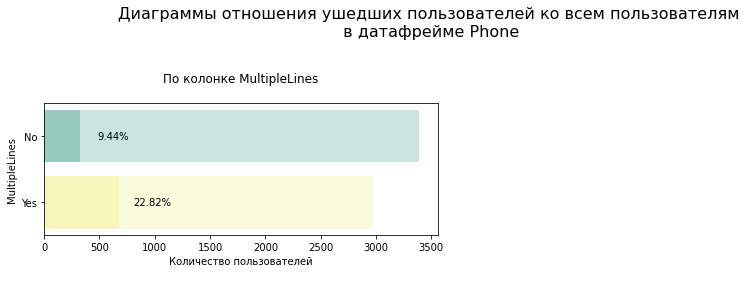

In [81]:
telecommunication_analysis.barplot_features(telecommunication_analysis.phone,
                                            telecommunication_analysis.leaved_id, 'Phone')

Больше, чем у половины клиентов не подключена услуга ведения параллельных линий во время звонка. При этом отказов больше (`22.82%` против `9.44`) у тех, у кого данная услуга подключена.

В соотношении ушедших клиентов к общему числу клиентов не найдено каких-либо аномалий.

### dataset - personal_new.csv

In [82]:
telecommunication_analysis.fix_citizen_status()

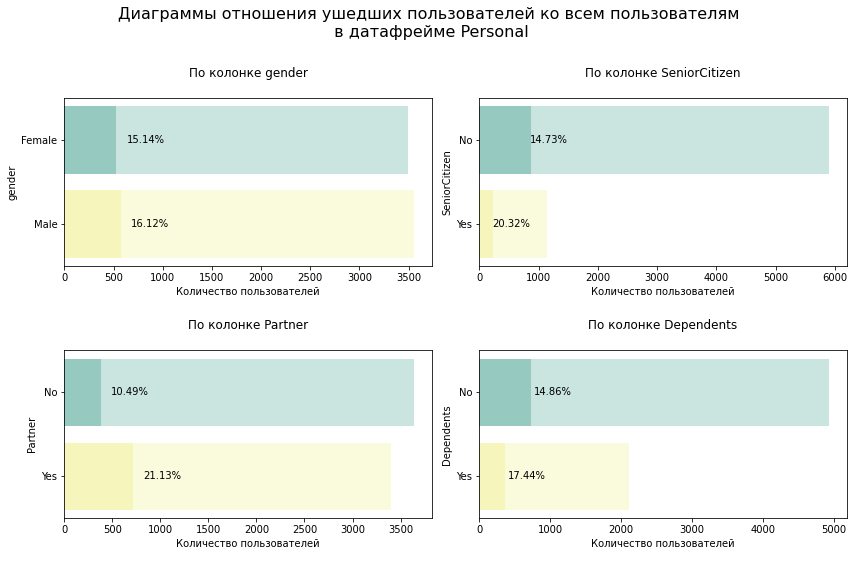

In [83]:
telecommunication_analysis.barplot_features(telecommunication_analysis.personal,
                                            telecommunication_analysis.leaved_id, 'Personal')

In [84]:
telecommunication_analysis.personal.value_counts().head(5)

gender  SeniorCitizen  Partner  Dependents
Male    No             No       No            1381
Female  No             No       No            1338
                       Yes      Yes            844
Male    No             Yes      Yes            822
Female  No             Yes      No             596
dtype: int64

Самая большая группа клиентов - одинокие люди, не имеющие пенсионного статуса и иждивенцев. При этом количество мужчин и женщин примерно одинаковое - `1381` и `1338` соответственно. На втором месте представлена группа женщин и мужчин, имеющих и партнеров, и иждивенцев - `844` и `822` клиента соответственно.

## Вывод

1. contact

a. Тип платежей

Больше половины оплачивают подписку ежемесячно (`55%`), в то время как `24.1%` оплачивают подписку раз в два года, ещё `20.9%` оплачивают годовую подписку.

Что касается клиентов, которые ушли, то тут картинка несколько иная:

* Клиенты, которые оплачивают подписку ежемесячно в абсолютном соотношение уходят больше всех. Однако в процентном соотношении таких меньше, всего - `10.5%`;
* Что касается двух друг групп, у которых годовой и 2х годовой план подписки, то здесь уже уходят `21.25%` и `22.48%` соответственно.

Наблюдается интересная ситуация, когда лояльные клиенты, готовые оплачивать сервис на год и более уходят чаще. Это может быть связано с несколькими факторами:
* Вероятно, нельзя менять корректировать выбранный пакеты услуг. В связи с чем, по истечению срока, клиенты выбирают другой, более выгодный сервис;
* Возможно, что среднее время пользованием услуг в данном регионе составляет 2 года.

b. Уведомление по электронной почте

Больше клиентов (`4171`) получают уведомления только по электронной почте, чем получают обычной почтой (`2872`). При этом те, кто получают по электронной почте реже уходят, тем те, кто получает физический носитель.

c. Способ оплаты

Здесь данные распределены примерно по ровну.

* Первая часть оплачивает автоматически с помощью кредитных карт (`21.6%`) и банковского перевода (`21.9%`).
* Вторая часть оплачивает в ручном режиме: наибольший процент (`33.6%`) прибегает к услуге Electronic check, на втором месте Mailed check (`22.9%`).

Вероятно, что клиенты, которые используют автоплатеж являются более лояльными, чем те, кто платит в ручном режиме.

2. internet 

Самая популярная услуга: обычный интернет с двумя типами подключения `Fiber optic` и `DSL` без дополнительных опций. Самая популярная дополнительная опция - `StremingTV` и `StreamingMovie`.

В соотношении ушедших клиентов к общему числу клиентов не найдено каких-либо аномалий.

3. phone

Больше, чем у половины клиентов не подключена услуга ведения параллельных линий во время звонка. При этом отказов больше (`22.82%` против `9.44`) у тех, у кого данная услуга подключена.

В соотношении ушедших клиентов к общему числу клиентов не найдено каких-либо аномалий.

4. personal

Самая большая группа клиентов - одинокие люди, не имеющие пенсионного статуса и иждивенцев. При этом количество мужчин и женщин примерно одинаковое - `1381` и `1338` соответственно. На втором месте представлена группа женщин и мужчин, имеющих и партнеров, и иждивенцев - `844` и `822` клиента соответственно.

## План работы (представлен в начале)

1. Изучение поставленной задачи;
1. Получение первоначальной информации о проекте;
2. Анализ имеющейся информации. Работа с данными: обработка некорректных значений, аномалий и пропусков.
3. Разделение выборки на `features` and `target`;
4. Feature engineering;
5. Поиск оптимальной модели;
6. Тестирование модели;
7. Вывод.

## Вопросы 

Уточняющих вопросов не имеется.

## Цель проекта

Определить, уйдет ли клиент по имеющимся признакам. Целевой признак - `EndDate`, если значение имеется (не равное `No`), то клиент ушел. 


# Обучение модели

## Работа с features и target

Получим полный датасет путем объединения всех имеющихся данных:

In [85]:
telecommunication_analysis.concat_datasets()

Количество уникальных пользователей в первоночальном датасете: 7043
Количество строк в полном датасете: 7043


Количество уникальных пользователей соответствует количеству уникальных клиентов в полном датасете. Это свидетельствует о том, что данные объеденины корректно. 

Как стало понятно из EDA, одним из важных факторов уйдет клиент или останется является продолжительность контракта. Добавим новый признак:

In [86]:
telecommunication_analysis.get_features()

In [87]:
telecommunication_analysis.df_full['duration'].sample(5)

customerID
4304-XUMGI    1523
0988-AADSA    2191
5075-JSDKI    1798
9500-WBGRP    2102
4855-SNKMY      92
Name: duration, dtype: int64

Новый признак `duration` обозначает продолжительность обслуживания в днях.

Разделим выборку на `features` и `target`. Цель проекта - определить, уйдет клиент или нет. Это бинарная классификация, в связи с этим также приведем целевое значение к виду `0` - клиент не ушел, `1` - клиент ушел:

In [88]:
telecommunication_analysis.features_train_splitter()

Размер выборки признаков: строк - 7043, столбцов - 17
Размер целевой выборки: строк - 7043


In [89]:
x = telecommunication_analysis.features.isna().sum().sort_values(ascending=False)
x[x>0]

TechSupport         1526
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [90]:
del x

В признаках же после объединения появились пропуски. Заменим их на заглушки: 

In [91]:
telecommunication_analysis.features = telecommunication_analysis.features.fillna('NoValue')

In [92]:
telecommunication_analysis.features.isna().sum().sort_values(ascending=False).head(1)

Type    0
dtype: int64

В признаках больше нет пропусков. Проанализируем их на предмет мультиколлинеарности:

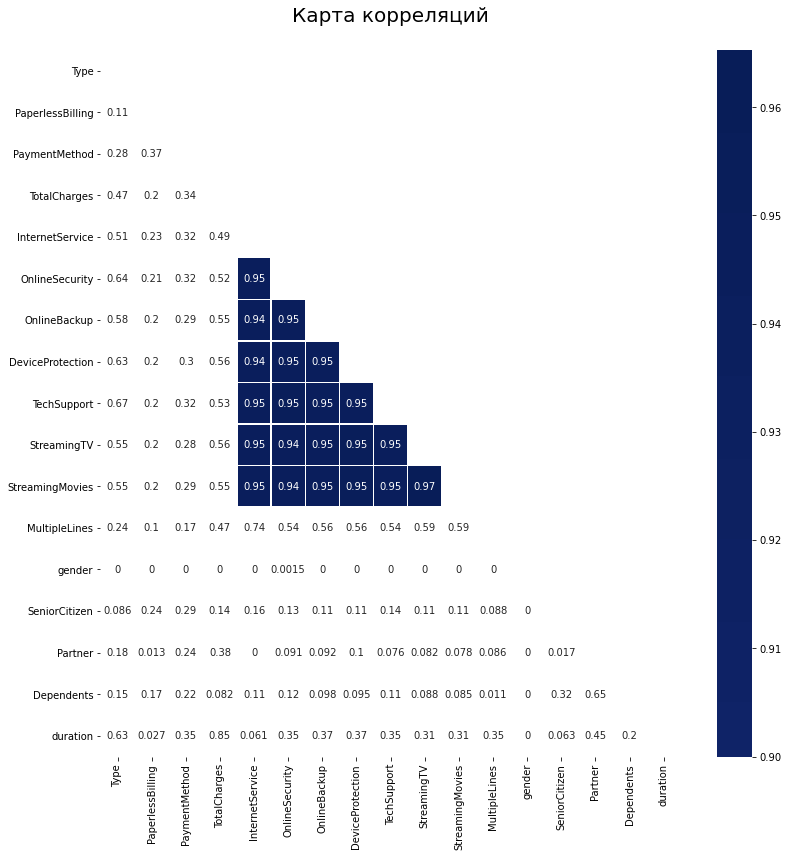

In [93]:
telecommunication_analysis.features_corr()

На тепловой карте наблюдается сильная коллинеарность между услугами, которые предоставляет оператор. Для борьбы с мультиколленеарностью заменен эти признаки одним признаком - с количеством услуг:

In [94]:
telecommunication_analysis.fix_corr_feature()

In [95]:
telecommunication_analysis.features['AmountOfService'].sample(3)

customerID
6769-DCQLI    5
3195-TQDZX    0
9921-ZVRHG    1
Name: AmountOfService, dtype: int64

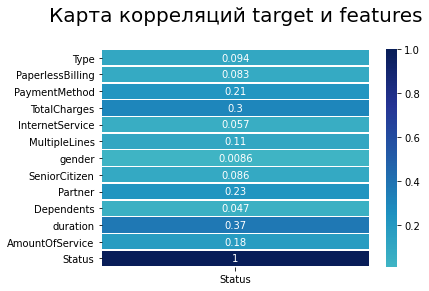

In [96]:
telecommunication_analysis.target_features_corr()

Корреляция таргета с признаками умеренная, утечки не наблюдается. Посмотрим на дисбаланс классов в `target`:

In [97]:
telecommunication_analysis.target.value_counts().reset_index()

,index,Status
0,0,5942
1,1,1101


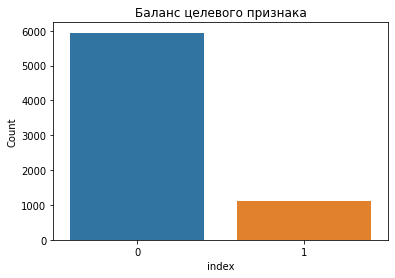

In [98]:
x = telecommunication_analysis.target.value_counts().reset_index()
sns.barplot(x='index',y='Status',data=x)
plt.title('Баланс целевого признака')
plt.ylabel('Count')
plt.show()

Наблюдается дисбаланс классов, однако для наших целей была выбрана метрика roc-auc, которая является не чувствительной к дисбалансу. В связи с чем перейдем к обучением моделей.

In [99]:
telecommunication_analysis.train_test_splitter()

## Поиск наилучшей модели

In [100]:
telecommunication_analysis.train_all_models(print_status=True)

Лучшая модель "LogisticRegression" на трейне имеет оценку roc_auc: 0.761.
Лучшая модель "RandomForestClassifier" на трейне имеет оценку roc_auc: 0.827.
Лучшая модель "CatBoostClassifier" на трейне имеет оценку roc_auc: 0.869.
Лучшая модель "LGBM" на трейне имеет оценку roc_auc: 0.897.


In [101]:
results = {
    'model' : 
        [*telecommunication_analysis.models.keys()],
    'ROC_AUC_score' : 
        [telecommunication_analysis.models[value]['score'] 
         for value in telecommunication_analysis.models.keys()],
    'time' : 
        [telecommunication_analysis.models[value]['time'] 
         for value in telecommunication_analysis.models.keys()],
    }
results = (pd.DataFrame(results)).set_index('model').sort_values(by='ROC_AUC_score', ascending=False)
results.style.format({'ROC_AUC_score': "{:.3f}",'time': "{:.2f} сек."})

,ROC_AUC_score,time
model,,
LGBM,0.897,216.47 сек.
CatBoost,0.869,105.83 сек.
RandomForestClassifier,0.827,50.30 сек.
LogisticRegression,0.761,43.59 сек.


По итогам обучения четырех моделей с использованием метрики `ROC_AUC` на первом месте оказалась модель `LGBM` с результатом `0.897`. Выведем модель в отдельную переменную, обучим ее и посмотрим на матрицу ошибок и важность признаков:

# Тестирование модели

Лучшей моделью по результатам тестирования оказалась модель `LGBM` c результатом `0.897`. Посмотрим, на результат в тестовых данных:

In [102]:
telecommunication_analysis.features_test = Telecommunication.LGBM_features_transformation(telecommunication_analysis.features_test)
predicts = telecommunication_analysis.LGBM.predict(telecommunication_analysis.features_test)
y_pred_prob = telecommunication_analysis.LGBM.predict_proba(telecommunication_analysis.features_test)[:, 1]

In [103]:
score = roc_auc_score(telecommunication_analysis.target_test,
                      y_pred_prob)
score_accuracy = accuracy_score(telecommunication_analysis.target_test, predicts)
print('ROC_AUC score на тестовой выборке: {:.3f}'.format(score))
print('Accuracy_score на тестовой выборке: {:.3f}'.format(score_accuracy))

ROC_AUC score на тестовой выборке: 0.927
Accuracy_score на тестовой выборке: 0.924


На тестовой выборке модель показала так же отличные результаты. Финальная оценка `ROC_AUC` на тестовых данных составила `0.927`,а `Accuracy_score` составила `0.924`. Посмотрим `ROC_AUC_curve`:

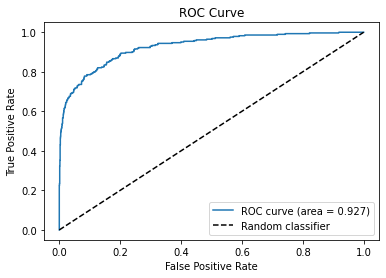

In [104]:
Telecommunication.plot_roc_auc_score(telecommunication_analysis.target_test,
                                     y_pred_prob)

Взглянем на матрицу ошибок:

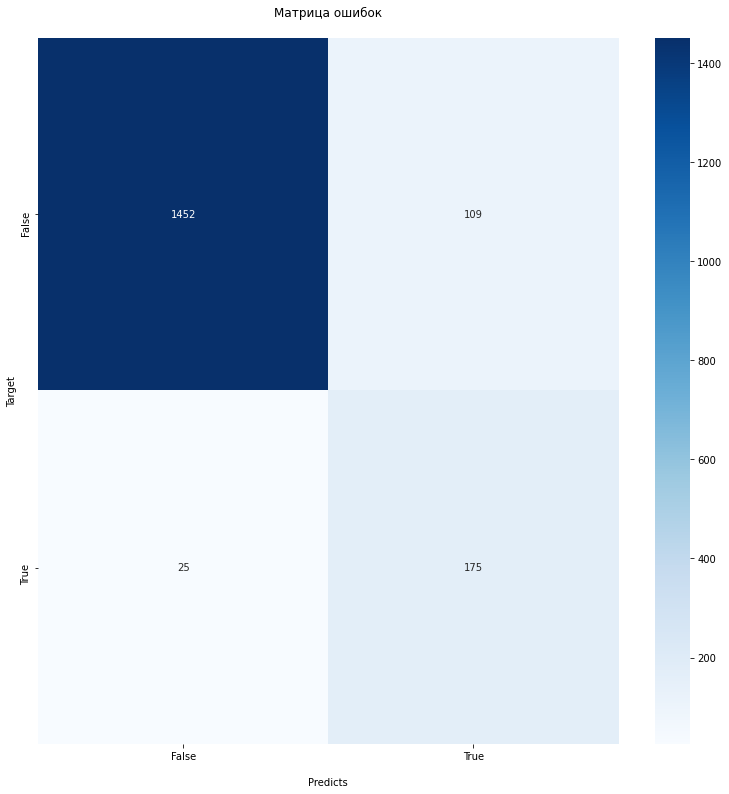

In [105]:
Telecommunication.plot_confusion_matrix(predicts,
                                        telecommunication_analysis.target_test)

Можно сделать следующие выводы:

1. Модель хорошо предсказывает тех клиентов, которые не собираются уходить;
2. Так же модель достаточно хорошо справляется с предсказанием клиентов, которые действительно собираются уйти. 
3. При этом, стоит отметить, что ~`40%` клиентов, отмеченных моделью как "уходящих", таковыми не являются. 

Таким образом модель хорошо справляется со своей задачей. С ее помощью можно находить группу риска и проводить с ними определенную работу, например: скидки, купоны, промокоды, различные программы лояльности.

Посмотрим, какие признаки являются наиболее важными при составлении прогноза:

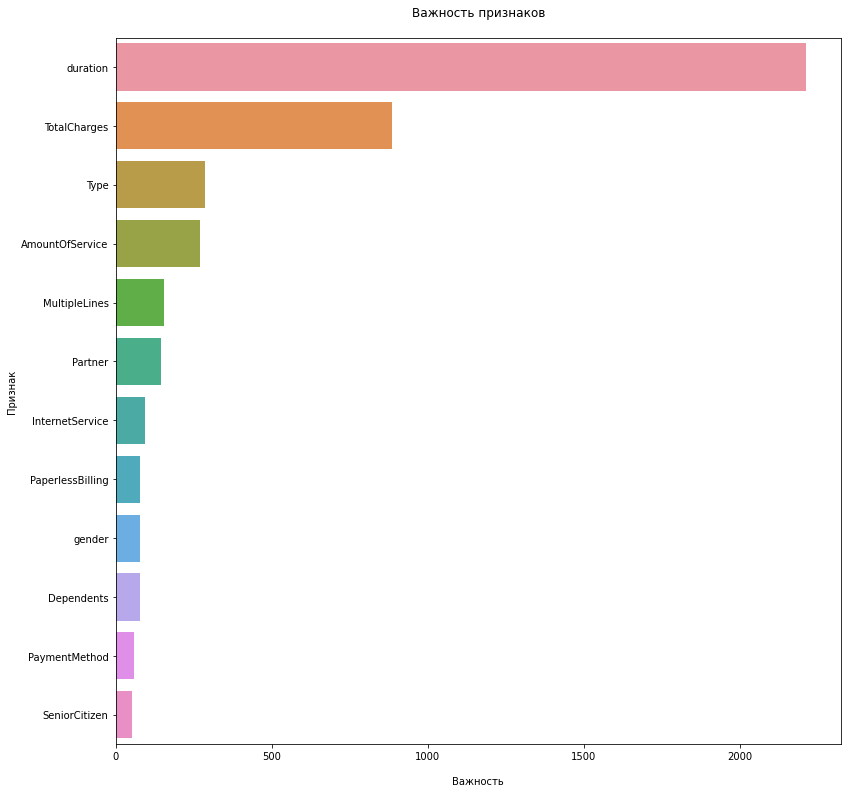

In [106]:
telecommunication_analysis.plot_features_importances(telecommunication_analysis.LGBM.best_estimator_.feature_importances_,
                                                     telecommunication_analysis.features_train.columns)

* Самый важный признак: `Duration` - срок "жизни" клиента;
* На втором месте - `TotalCharges`;
* На третьем месте - `Type`;
* Четвертым важным признаком является `AmountOfService` - признак, объеденный нами из других (мультиколлинеарных) признаков.

## Вывод

a. Для целей прогнозирования все датасеты были объеденины в один датасет. Затем данные были разбиты на:
1. Признаки и целевой признак. Целевой признак был получен из колонки `EndDate` и приведен к виду `0` - клиент не ушел, `1` - клиент ушел, что позволило свести задачу к задаче классификации;
2. Тренировочные данные и тестовые.

b. Были выделены новые признаки, такие как:
1. `Duration` - продолжительность обслуживания в днях;
2. `AmountOfService` - услуги были сильно скоррелированы. В связи с чем было принято решение объединить их в один признак.

c. Был исследован дисбаланс классов

d. С помощью метода `RandomizedSearchCV` была найдена наилучшая модель - `LGBM` с результатом `ROC_AUC` на обучающей выборке: `0.897`. На тестовой выборке же результат составил `0.903`.

Матрица ошибок показала, что модель хорошо предсказывает тех клиентов, кто действительно ушел или остался. Так же наблюдается `40%` FP, что не так страшно для целей нашей задачи.

Самый важный признак: `Duration` - срок "жизни" клиента, на втором месте - `TotalCharges`, на третьем месте - `Type` , четвертым важным признаком является `AmountOfService` - признак, объеденный нами из других (мультиколлинеарных) признаков.


# Отчет о проделанной работе

План работы состоял из следующих пунктов:

1. Изучение поставленной задачи;
2. Получение первоначальной информации о проекте;
3. Анализ имеющейся информации. Работа с данными: обработка некорректных значений, аномалий и пропусков.
4. Разделение выборки на `features` and `target`;
5. Feature engineering;
6. Поиск оптимальной модели;
7. Тестирование модели;
8. Вывод.


Сама же работа была поделена на несколько частей: `a` - `c`. 

a. Вводна часть

В первой части были выполнены пункты плана `1` по `3`:
- Была изучена поставленная задача, которая сводилась к бинарной классификации - нужно определить, уйдет ли клиент от оператора связи или нет. 
- Было произведено первичное ознакомление с данными, которые состояли из четырех датасетов. Каждый датасет имел колонку `customerID`, которая являлась первичным ключем и отображала id клиента:
  1. `contact` - состоял из `7043` уникальных значений, которые были представлены в таблице: `BeginDate`,`EndDate`, `Type`,`PaperlessBilling`,`MonthlyCharges`,`TotalCharges`. Данные колонки предоставляли информацию о том, когда клиент заключил договор, когда расторг, как и сколько платил за предоставляемые услуги;
  2. `personal` - датасет представлял собой первичную информацию о клиентах: их пол, семейный статус, наличие партнера и иждивенцев;
  3. `internet` - состоял из `5517` строк и `7` столбцов, которые отображали тип подключения клиента и различные услуги, которыми он пользуется;
  4. `phone` - состоял из `6361` строки и `1` колонки, которая отображала наличие нескольких линий у клиента;


- В каждом датасете данные были проверены на корректность типов, аномалии и пропуски.  
   1. В датасете `contact` были обнаружены не совпадения типов данных и данных в столбцах `TotalCharges` и `BeginDate`, что в последствии было устранено. Так же было обнаружено 10 пропусков в `TotalChargers`, которые возникли для новых клиентов, которые пришли перед выгрузкой базы данных;
   2. В остальных датасетах было множество пропусков, которые возникали по тем или иным причинам (например клиент не пользуется интернетом, поэтому данных о них попросту нет). Некоторые данные были преобразованы из вида `1` и `0` в `yes` и `no`. 


- Была собрана первичная информация о данных и составлены портеры клиентов, которые находятся в зоне риска для компании. Такими клиентами оказались: клиенты, которые пользуются услугами долгое время, имеют годовой или 2-х годовой план подписки, с подключенной услугой MultipleLines. Дальше идут клиенты с различными вариациями   тех или иных признаков;

б. Поиск оптимальной модели

Во второй части были выполнены с `4` по `7` пункты планы. 

- Данные были разделены на `features` и `target`;
- `target` был выделен из колонки `EndDate`, которая содержала в себе дату окончания обслуживания клиента. Так же были выделены следующие признаки: `duration` и `amount_of_service`. `Duration` - срок обслуживания клиента (`BeginDate` - `EndDate`/`Дата выгрузки базы`), это было сделано для того, чтобы удалить столбец `EndDate`, не допустить утечку таргета и получить информацию, которую нес данный признак. Количество сервисов, которыми пользуется клиент - `amount_of_service` возник, как средство борьбы с мультиколлениарностью. Таким образом несколько признаков было заменено одним;
- Данные были разделены на `train`  и `test`. Затем был произведен поиск оптимальной модели из 4-х вариантов:  `LogisticRegression`, `RandomForesetClassifier`, `CatBoostClassifier`,`LGBM`. В каждой модели с помощью пайплайна для обработки данных был осуществлен поиск наилучших параметров с использованием `RandomizedSearchCV` с параметром `cv` (cross-validation) = 5. Лучший результат по итогам обучения показала модель `LGBM` с метрикой `ROC_AUC` - `0.897`. 
- На тестовых данных модель показала результат `0.927` `ROC_AUC` и `0.924` `accuracy_score`. ROC curve выглядит следующим образом:

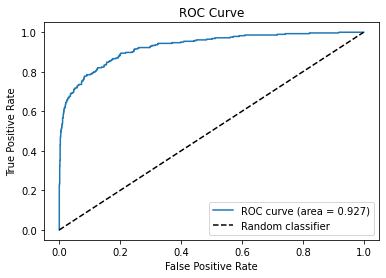

- Матрица ошибок: 

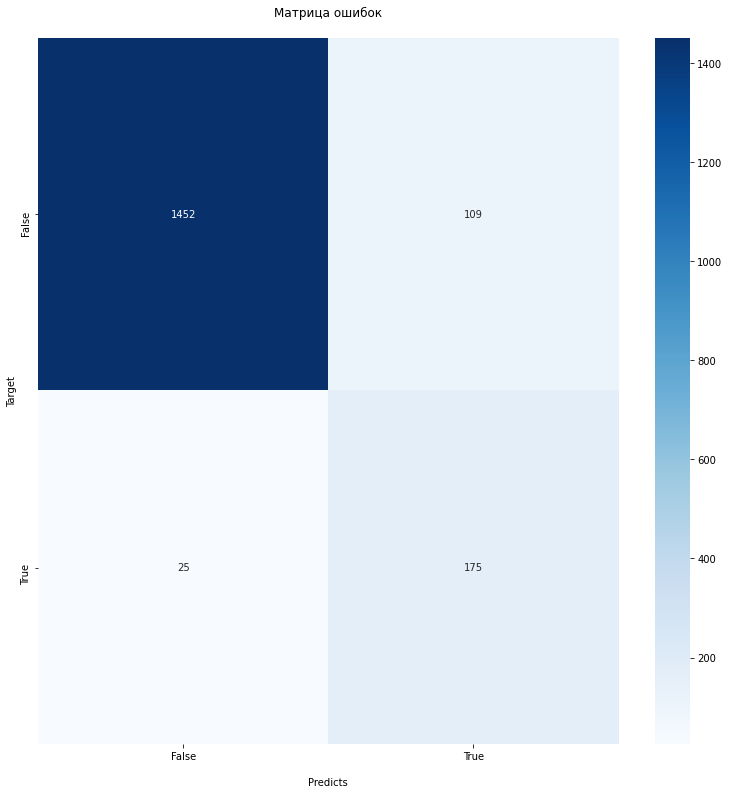


Из матрицы ошибок видно, что:
1. Модель хорошо предсказывает тех клиентов, которые не собираются уходить;
2. Так же модель достаточно хорошо справляется с предсказанием клиентов, которые действительно собираются уйти. 
3. При этом, стоит отметить, что ~`40%` клиентов, отмеченных моделью как "уходящих", таковыми не являются. 

Таким образом модель хорошо справляется со своей задачей. С ее помощью можно находить группу риска и проводить с ними определенную работу, например: скидки, купоны, промокоды, различные программы лояльности.

При этом, если разбирать важность признаков для модели, то график выглядит следующим образом: 

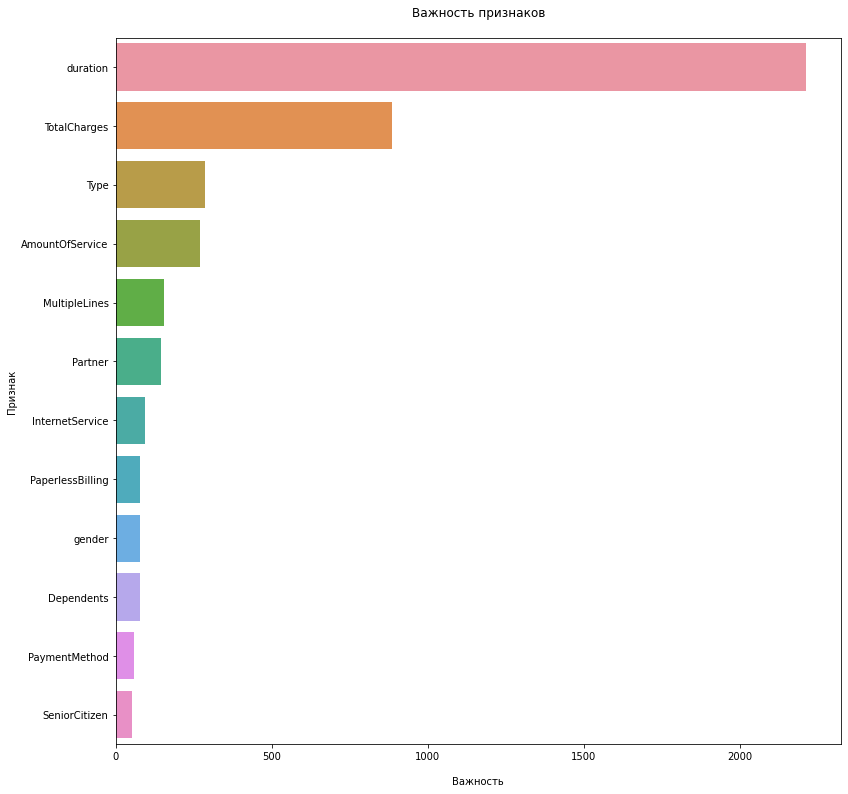

* Самый важный признак: `Duration` - срок "жизни" клиента;
* На втором месте - `TotalCharges`;
* На третьем месте - `Type`;
* Четвертым важным признаком является `AmountOfService` - признак, объеденный нами из других (мультиколлинеарных) признаков.


c. Отчет о проделанной работе


Таким образом, можно заключить, что задача проекта выполнена. Целевое значение метрики достигнуто, модель справляется со своей задачей. С ее помощью можно предсказывать, является ли клиент в зоне риска с точки зрения компании и нуждается ли он в каких-либо дополнительных мерах для повышения лояльности. 

v3.1 fix.

В ходе проекта было несколько проблем, с которыми пришлось столкнуться:

1. Главная проблема - отсутствие целевого признака, который в последствии пришлось выделять из другого признака `EndDate`. Так, если в данной колонке наблюдалось значение `No`, значит клиент не ушел, в противном же случае клиент ушел. Таким образом новый целевой признак имел вид `1` (клиент ушел) и `0` (клиент не ушел), что соответствует нашей задаче классификации;
2. Данные хранились в разных датасетах. В связи с чем появилась потребность в их объединении и проверки на корректность объединения. Данная проблема была преодолена в процессе работы;
3. Имелись пропуски. Так, например, при попытке изменить тип данных в столбце `TotalCharges` были найдены пустые строки для новых клиентов. Было принято решение заменить пропуски на `MonthlyCharges` для новых клиентов;
    
Выделим ключевые шаги работы над проектом:

1. Подготовка рабочей среды;

2. Загрузка и изучение данных;

3. Предобработка и исследовательский анализ данных;

5. Подготовка данных к обучению;

6. Обучение модели;

7. Проверка модели;

8. Анализ получившихся результатов. 